# Librerias

In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
import pathlib
from pathlib import Path  

In [2]:
import pickle
import sys
from pathlib import Path

# Añadir el directorio raíz del proyecto a sys.path
module_path = Path('/Users/Cesar/Desktop/Proyecto-CSG/').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# Añadir el directorio que contiene 'new_spectral_metric' a sys.path
new_spectral_metric_path = module_path / '/Users/Cesar/Desktop/Proyecto-CSG/new_spectral_metric/'
if new_spectral_metric_path not in sys.path:
    sys.path.append(str(new_spectral_metric_path))

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from new_spectral_metric.new_estimator import CumulativeGradientEstimator
from new_spectral_metric.new_visualize import make_graph
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path

# DATASET DESDE DIRECTORIO 

In [3]:

directorio_dataset = ('../Datasets/Perros y Gatos')
directorio_dataset = pathlib.Path(directorio_dataset)

# Lectura de la carpeta train
directorio_train = ('../Datasets/Perros y Gatos/train')
directorio_train = pathlib.Path(directorio_train)

# Lectura de la carpeta test
directorio_test = ('../Datasets/Perros y Gatos/test')
directorio_test = pathlib.Path(directorio_test)


total_dataset = len(list(directorio_dataset.glob('*/*/*.jpg')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_train = len(list(directorio_train.glob('*/*.jpg')))  # Cuenta la cantidad de imagenes de train
total_test = len(list(directorio_test.glob('*/*.jpg')))  # Cuenta la cantidad de imagenes de test

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes train: {total_train}")
print(f"Total imagenes test: {total_test}")

Total imagenes dataset: 697
Total imagenes train: 557
Total imagenes test: 140


In [4]:
# Definir el batchsize del dataset completo
batch_size_total = total_dataset

In [5]:
# Dimensiones de imagen y tamaño de batch en train
img_height = 32
img_width = 32
#batch_size = 32
batch_size_train = total_train

In [6]:

import tensorflow as tf
import pathlib

# Data splitting (entrenamiento y validación)
train_images = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_train,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size_train)

Found 557 files belonging to 2 classes.


In [7]:
# Dimensiones de imagen y tamaño de batch en test
img_height = 32
img_width = 32
#batch_size = 32
batch_size_test = total_test

In [8]:
# Data splitting (entrenamiento y validación)
test_images = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_test,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size_test)

Found 140 files belonging to 2 classes.


In [9]:

class_counts_total = {p.name: len(list(p.glob('*.jpg'))) for p in directorio_dataset.glob('*/*')}
class_counts_train = {p.name: len(list(p.glob('*.jpg'))) for p in directorio_train.glob('*')}
class_counts_test = {p.name: len(list(p.glob('*.jpg'))) for p in directorio_test.glob('*')}


# Mostrar el total de imágenes por clase en train
print("\nTotal de imágenes por clase en train:")
for class_name, count in class_counts_train.items():
    print(f"Clase: {class_name}, Número de imágenes: {count}")
print(f"Total imagenes train: {total_train}")

# Mostrar el total de imágenes por clase en test
print("\nTotal de imágenes por clase en test:")
for class_name, count in class_counts_test.items():
    print(f"Clase: {class_name}, Número de imágenes: {count}")
print(f"Total imagenes test: {total_test}")


Total de imágenes por clase en train:
Clase: cats_train, Número de imágenes: 279
Clase: dogs_train, Número de imágenes: 278
Total imagenes train: 557

Total de imágenes por clase en test:
Clase: cats_test, Número de imágenes: 70
Clase: dogs_test, Número de imágenes: 70
Total imagenes test: 140


In [10]:
# Nombres de las clases
class_names_train = list(class_counts_train.keys())
class_names_test = list(class_counts_test.keys())
#class_names_total = sorted(list(set(class_names_train + class_names_test)))
class_names_total = list(class_counts_total.keys())

# Mostrar el número de clases y los nombres
print(f"\nNúmero de clases en train: {len(class_names_train)}")
print(f"Nombres de las clases en train: {class_names_train}")

print(f"\nNúmero de clases en test: {len(class_names_test)}")
print(f"Nombres de las clases en test: {class_names_test}")

print(f"\nNúmero total de clases en el dataset: {len(class_names_total)}")   # Este valor cambio si el nombre de las clases es diferente
print(f"Nombres de todas las clases en el dataset: {class_names_total}")     # Este valor tambien cambia si el nombre de las clases es diferente


Número de clases en train: 2
Nombres de las clases en train: ['cats_train', 'dogs_train']

Número de clases en test: 2
Nombres de las clases en test: ['cats_test', 'dogs_test']

Número total de clases en el dataset: 4
Nombres de todas las clases en el dataset: ['cats_test', 'dogs_test', 'cats_train', 'dogs_train']


In [11]:
for images, labels0 in train_images.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(557, 32, 32, 3)


# Dataset complexity using CSG

c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Cesar\Desktop\Proyecto-CSG\new_spectral_metric\new_visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
C:\Users\Cesar\Desktop\Proyecto-CSG\new_spectral_metric\new_visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


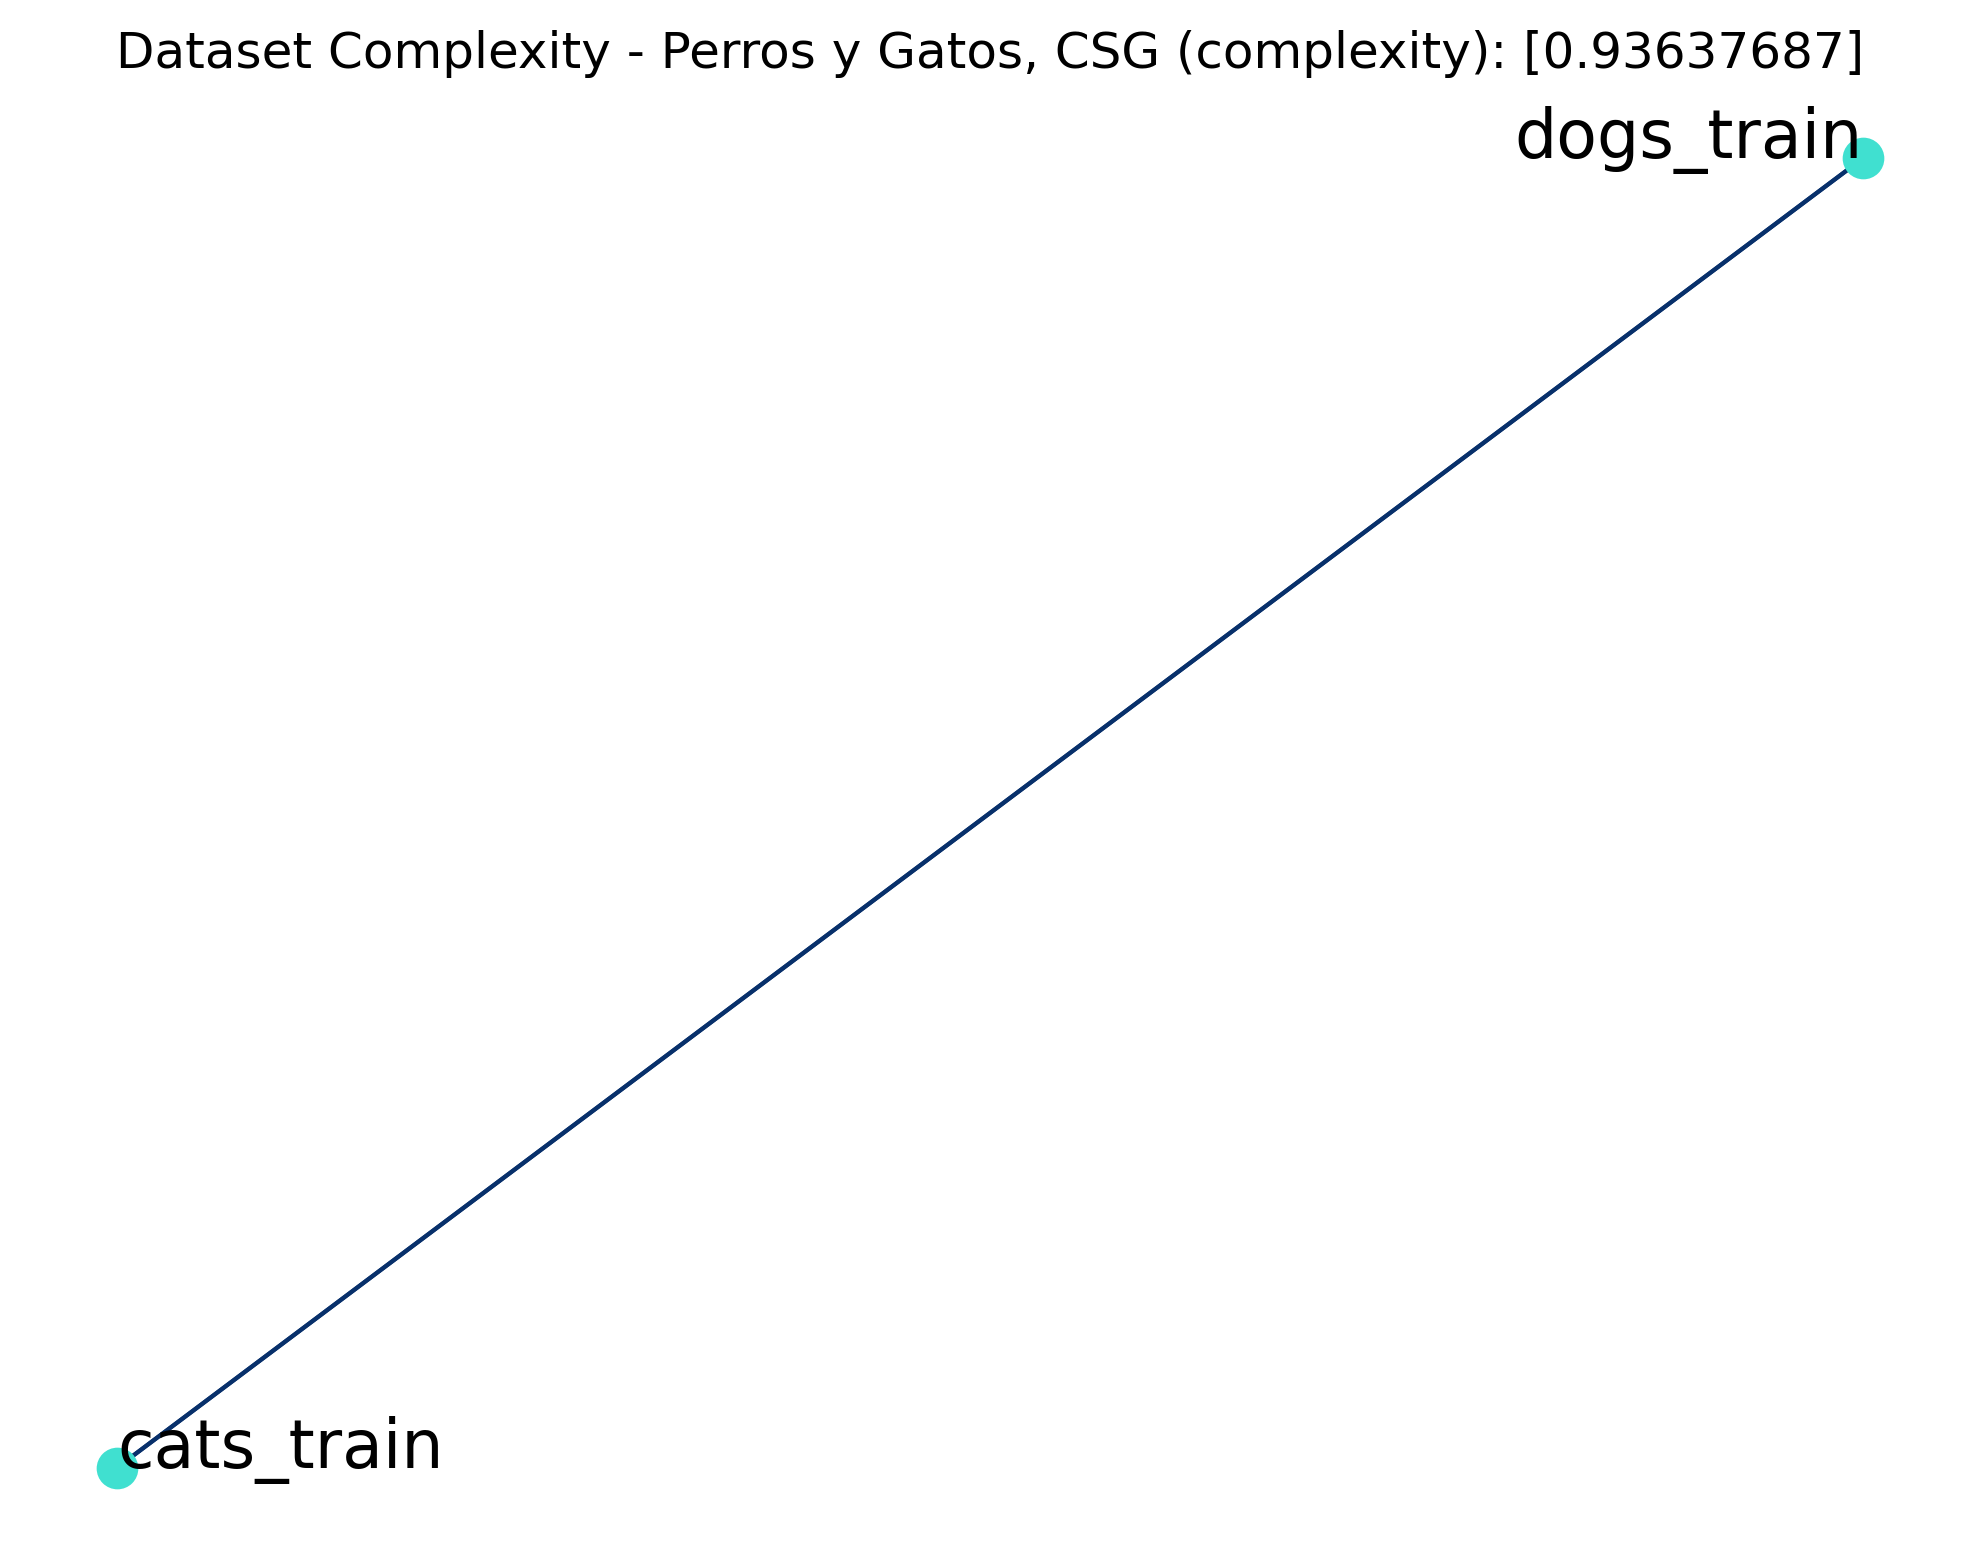

In [12]:
# CIFAR-10 Two classes
fully_dataset_train = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels_train = numpy_all_labels.reshape(numpy_all_labels.shape[0],)

estimator = CumulativeGradientEstimator(M_sample=557, k_nearest=10)
estimator.fit(data=fully_dataset_train, target=fully_labels_train)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Dataset Complexity - Perros y Gatos, CSG (complexity): "+str(csg), classes=class_names_train)

# Calcular la similitud entre clases

In [13]:

from scipy.stats import entropy
import pandas as pd

# Calcular la entropía por clase  
entropy_per_class = entropy(estimator.W / estimator.W.sum(-1)[:, None], axis=-1)  

# Encontrar la clase menos confusa (menor entropía)  
least_confused_class_index = np.argmin(entropy_per_class)  
least_confused_class_name = class_names_train[least_confused_class_index]  

print("Class that is the least confused (lowest entropy):", least_confused_class_name)

Class that is the least confused (lowest entropy): cats_train


In [14]:

# Obtener los índices de los pares menos similares  
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))  

# Filtrar pares donde i != j para evitar pares de la misma clase  
pairs = [(i, j) for i, j in pairs if i != j]  

print("Least similar pairs")  
lst = []  
seen_pairs = set()  

# Iterar sobre los primeros 10 pares menos similares  
for i, j in pairs:  
    # Verificar si el par o su inverso ya ha sido visto  
    if (i, j) not in seen_pairs and (j, i) not in seen_pairs:  
        lst.append({"Intent pair": f"{class_names_train[i]} <> {class_names_train[j]}", "Similarity": estimator.W[i, j]})  
        seen_pairs.add((i, j))  
        seen_pairs.add((j, i))  
    
    # Detenerse después de encontrar 10 pares únicos  
    if len(lst) == 10:  
        break  

# Mostrar los resultados en un DataFrame  
print(pd.DataFrame(lst))

Least similar pairs
                Intent pair  Similarity
0  cats_train <> dogs_train    0.936377


# Obtener los nombres de las imagenes en train o test (dependiendo de lo que se quiera probar)

In [15]:
# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_train.glob('*/*.jpg')]

# Crear un mapeo de índices a rutas completas de archivo  
filenames_dict = {i: str(f) for i, f in enumerate(directorio_train.glob('*/*.jpg'))} 


# Calcular la similitud entre muestras

# 1. Visualizar las muestras (par de imagenes) menos similares entre la misma clase

Muestras menos similares entre las imágenes de la misma clase 

Clase: cats_train
	cat_544.jpg (cats_train) vs cat_224.jpg (cats_train), Similitud: 0.0498
	cat_387.jpg (cats_train) vs cat_224.jpg (cats_train), Similitud: 0.0693
	cat_224.jpg (cats_train) vs cat_399.jpg (cats_train), Similitud: 0.0713
	cat_151.jpg (cats_train) vs cat_224.jpg (cats_train), Similitud: 0.0718
	cat_224.jpg (cats_train) vs cat_331.jpg (cats_train), Similitud: 0.0723
	cat_316.jpg (cats_train) vs cat_224.jpg (cats_train), Similitud: 0.0723
	cat_207.jpg (cats_train) vs cat_224.jpg (cats_train), Similitud: 0.0728
	cat_224.jpg (cats_train) vs cat_494.jpg (cats_train), Similitud: 0.0728
	cat_269.jpg (cats_train) vs cat_224.jpg (cats_train), Similitud: 0.0728
	cat_224.jpg (cats_train) vs cat_74.jpg (cats_train), Similitud: 0.0732
Clase: dogs_train
	dog_505.jpg (dogs_train) vs dog_509.jpg (dogs_train), Similitud: 0.1851
	dog_505.jpg (dogs_train) vs dog_125.jpg (dogs_train), Similitud: 0.1973
	dog_403.jpg (dogs_train)

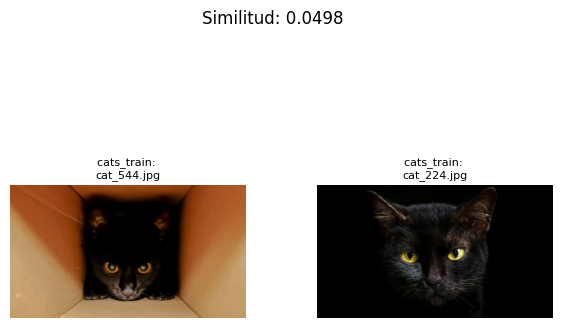

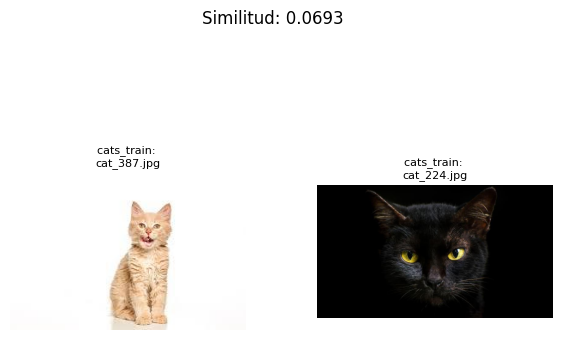

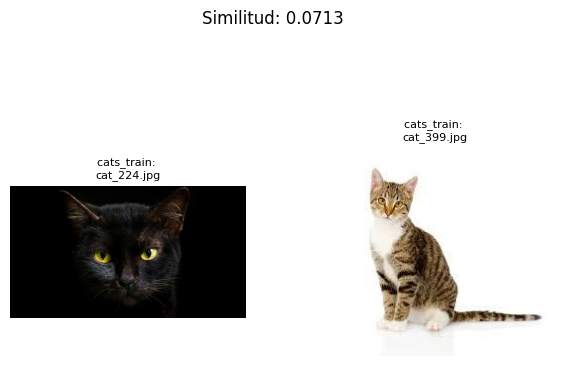

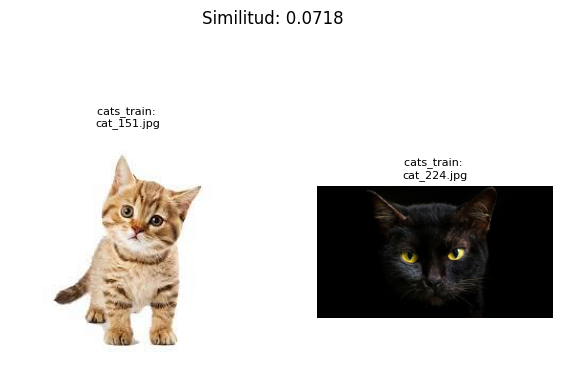

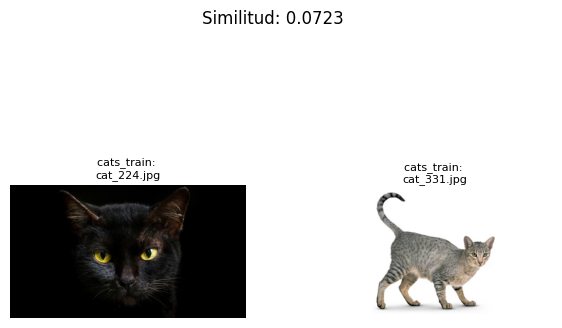

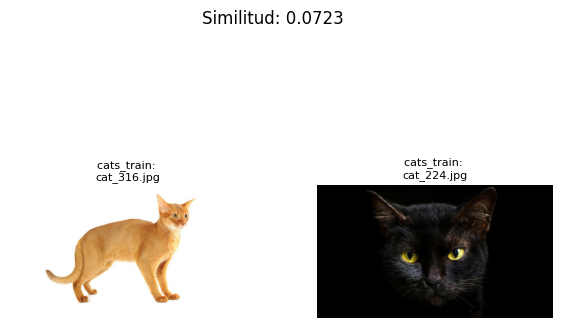

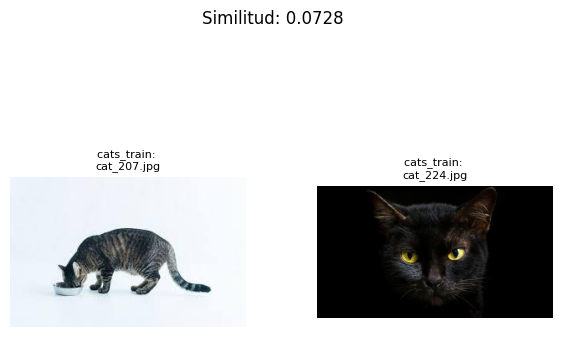

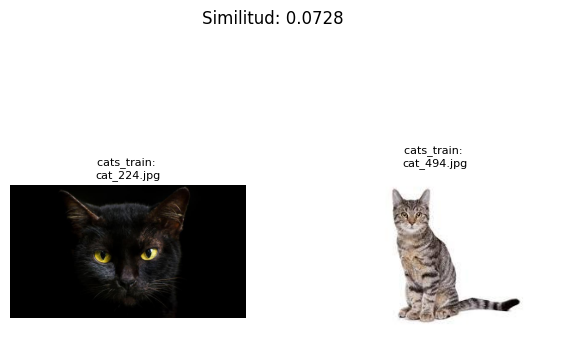

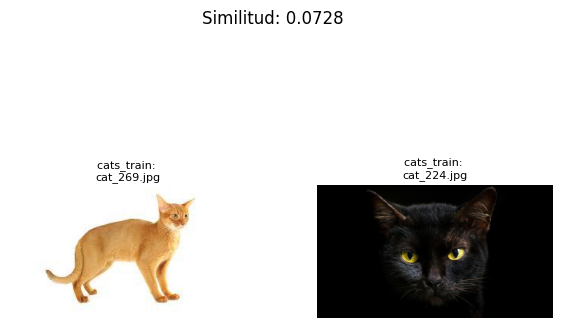

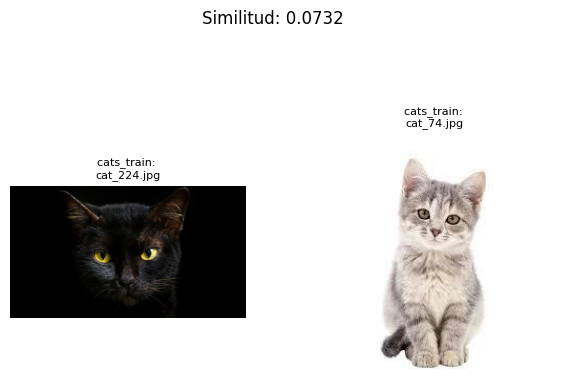

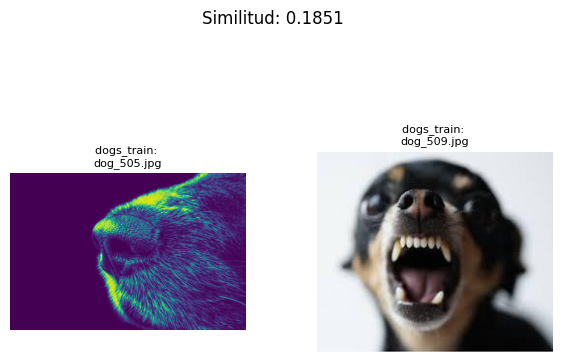

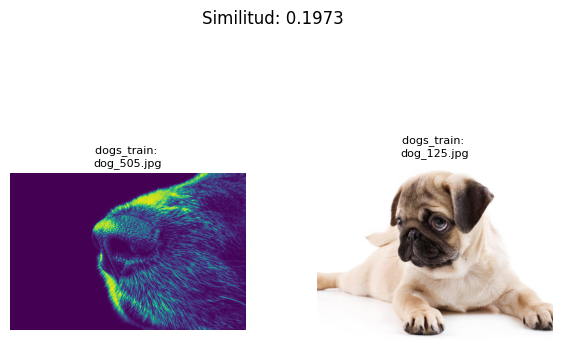

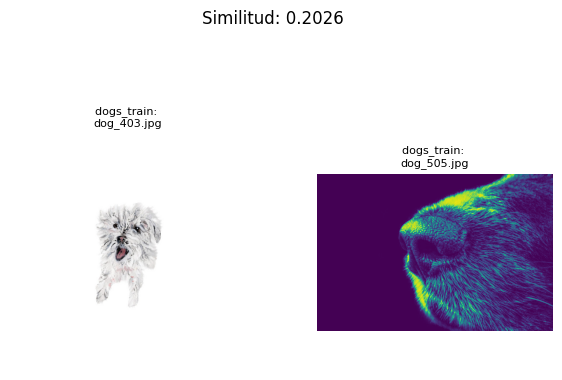

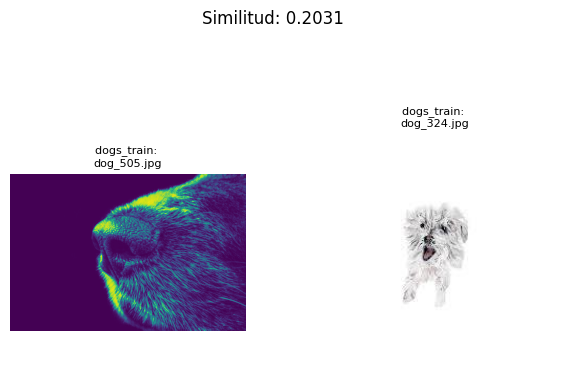

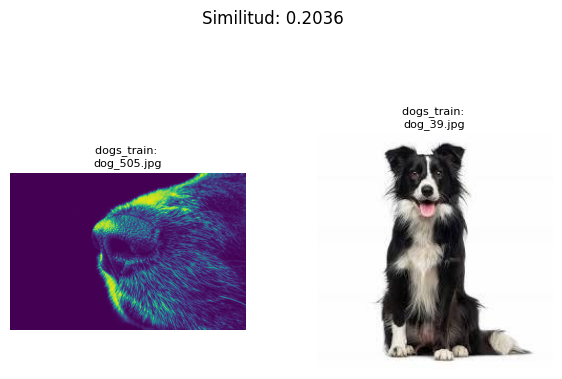

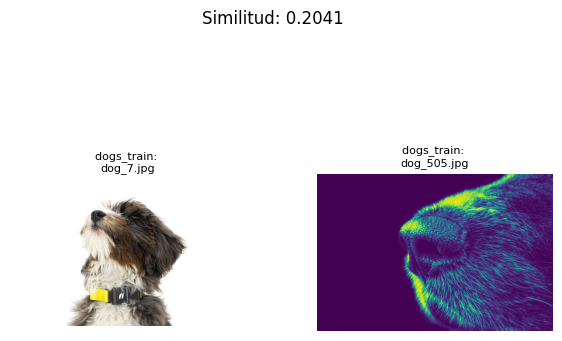

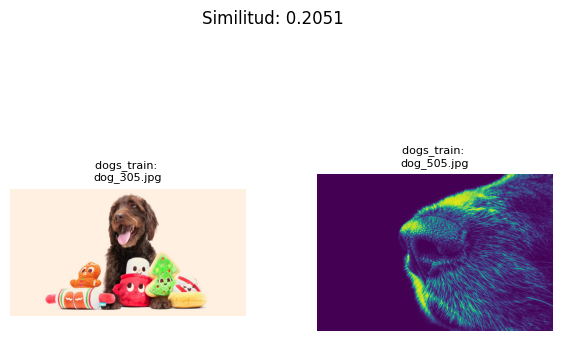

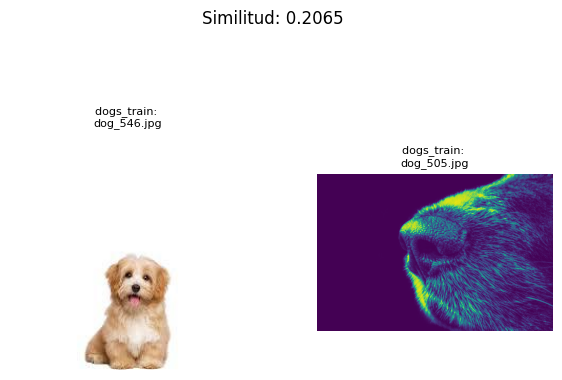

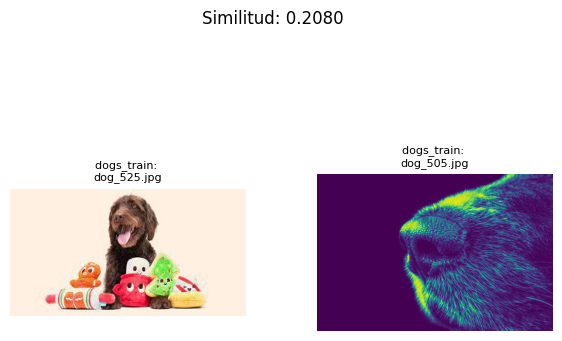

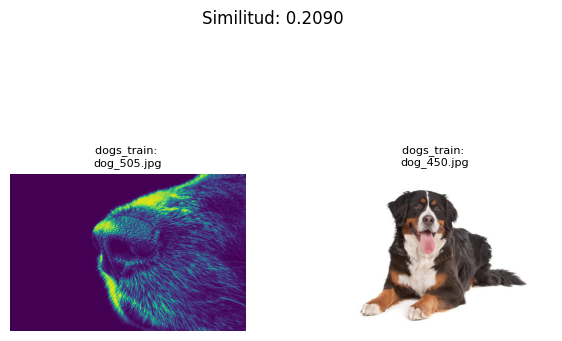

In [25]:

# Función para encontrar y mostrar las imágenes menos similares dentro de cada clase usando la matriz C  
def show_least_similar_using_C_all_classes(estimator, class_names, filenames_dict):  
    images_to_show = []  # Lista para almacenar las imágenes y sus detalles  

    # Primero, recorre las clases y genera la lista de descripciones  
    for class_intent in range(len(class_names)):  
        class_name = class_names[class_intent]  
        print(f"Clase: {class_name}")  
        
        # Obtener la matriz de similitud de las muestras dentro de la clase  
        C = estimator.C[class_intent]  
        
        # Ordenar los índices según las similitudes (de menor a mayor)  
        least_similar_indices = np.argsort(C, axis=None)  
        
        shown_pairs = set()  # Para rastrear los pares de índices ya mostrados  
        count = 0  
        show_samples = 10  # Número de muestras para visualizar la similitud  
        
        for idx in least_similar_indices:  
            if count >= show_samples:  
                break  
            
            # Convertir el índice plano a índice 2D  
            idx_2d = np.unravel_index(idx, C.shape)  
            
            # Saltar las comparaciones de una muestra consigo misma  
            if idx_2d[0] == idx_2d[1]:  
                continue  
            
            # Crear un par ordenado de índices para prevenir duplicados  
            index_pair = tuple(sorted((idx_2d[0], idx_2d[1])))  
            
            # Verificamos si el par ya fue mostrado  
            if index_pair in shown_pairs:  
                continue  
            
            shown_pairs.add(index_pair)  
            
            # Obtener los índices de las muestras en el dataset  
            source_idx = estimator.class_indices[class_intent][idx_2d[0]]  
            target_idx = estimator.class_indices[class_intent][idx_2d[1]]  
            
            # Verificar que los índices estén dentro de los límites del dataset  
            if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):  
                source_filename = Path(filenames_dict[int(source_idx)])  
                target_filename = Path(filenames_dict[int(target_idx)])  
                
                value = C[idx_2d]  
                
                # Formatear y mostrar la salida  
                print(f"\t{source_filename.name} ({class_name}) vs {target_filename.name} ({class_name}), Similitud: {value:.4f}")  
                
                # Agrega los detalles a la lista para visualización  
                images_to_show.append((source_filename, target_filename, class_name, value))  
                
                count += 1  
    
    # Luego, realiza la visualización de las imágenes  
    for source_filename, target_filename, class_name, value in images_to_show:  
        img_source = plt.imread(source_filename)  
        img_target = plt.imread(target_filename)  
        
        fig, axs = plt.subplots(1, 2, figsize=(7, 5))  
        axs[0].imshow(img_source)  
        axs[0].set_title(f"{class_name}: \n{source_filename.name}", fontsize=8) 
        axs[0].axis('off')  # Elimina los ejes para centrar la atención en la imagen  
        
        axs[1].imshow(img_target)  
        axs[1].set_title(f"{class_name}: \n{target_filename.name}", fontsize=8)  
        axs[1].axis('off') 
        plt.suptitle(f"Similitud: {value:.4f}")  
        plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Ajusta el espacio entre subtramas  
        plt.show()  


print("Muestras menos similares entre las imágenes de la misma clase \n")  
show_least_similar_using_C_all_classes(estimator, class_names_train, filenames_dict)

# 2. Visualizar las muestras (par de imagenes) menos similares entre las clases pares

Muestras menos similares entre imágenes de clases pares (distintas clases) 

Pares de Clases: cats_train y dogs_train
	cat_224.jpg (cats_train) vs dog_324.jpg (dogs_train), Similitud: 0.0679
	cat_224.jpg (cats_train) vs dog_403.jpg (dogs_train), Similitud: 0.0679
	cat_224.jpg (cats_train) vs dog_546.jpg (dogs_train), Similitud: 0.0703
	cat_224.jpg (cats_train) vs dog_39.jpg (dogs_train), Similitud: 0.0713
	cat_224.jpg (cats_train) vs dog_230.jpg (dogs_train), Similitud: 0.0723


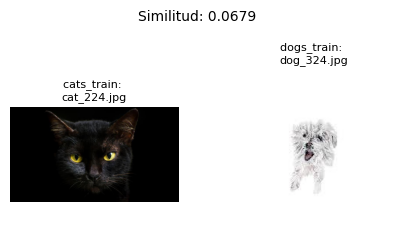

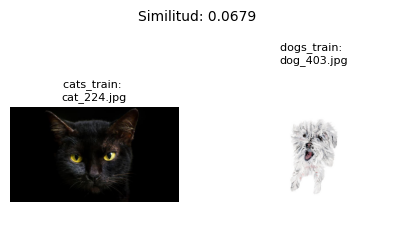

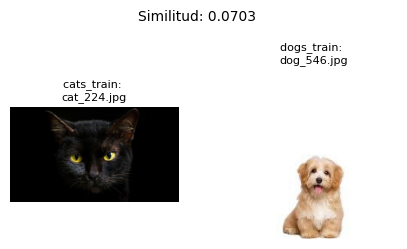

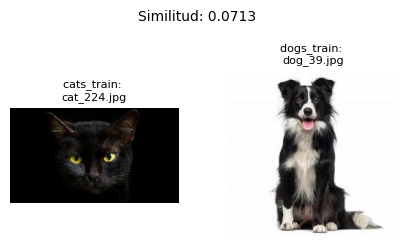

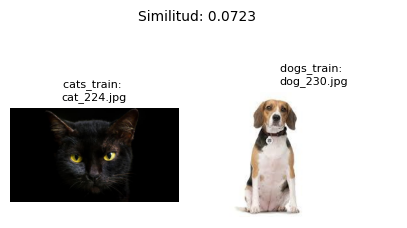

In [28]:
# Función para visualizar las imágenes menos similares entre pares de clases usando la matriz P 
 
def show_least_similar_between_class_pairs(estimator, class_names, filenames_dict):  
    images_to_show = []  # Lista para almacenar las imágenes y sus detalles  

    # Iterar sobre cada par de clases  
    for i in range(len(class_names)):  
        for j in range(i + 1, len(class_names)):  
            class_i_name = class_names[i]  
            class_j_name = class_names[j]  
            print(f"Pares de Clases: {class_i_name} y {class_j_name}")  
            
            # Obtener la matriz de similitud para el par de clases  
            P = estimator.P[(i, j)]  
            
            # Ordenar los índices según las similitudes (de menor a mayor)  
            least_similar_indices = np.argsort(P, axis=None)  
            
            shown_pairs = set()  # Para rastrear los pares de índices ya mostrados  
            count = 0  
            show_samples = 5  # Número de pares de muestras para visualizar la similitud  
            
            for idx in least_similar_indices:  
                if count >= show_samples:  
                    break  
                
                # Convertimos el índice plano a 2D  
                idx_2d = np.unravel_index(idx, P.shape)  
                
                # Crear un par ordenado de índices para prevenir duplicados  
                index_pair = tuple(sorted((idx_2d[0], idx_2d[1])))  
                
                # Verificamos si el par ya fue mostrado  
                if index_pair in shown_pairs:  
                    continue  
                
                shown_pairs.add(index_pair)  
                
                # Obtener los índices de las muestras en el dataset  
                source_idx = estimator.class_indices[i][idx_2d[0]]  
                target_idx = estimator.class_indices[j][idx_2d[1]]  
                
                # Verificar que los índices estén dentro de los límites del dataset  
                if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):  
                    source_filename = Path(filenames_dict[int(source_idx)])  
                    target_filename = Path(filenames_dict[int(target_idx)])  
                    
                    value = P[idx_2d]  
                    print(f"\t{source_filename.name} ({class_i_name}) vs {target_filename.name} ({class_j_name}), Similitud: {value:.4f}")  
                    
                    # Agrega los detalles a la lista para visualización  
                    images_to_show.append((source_filename, target_filename, class_i_name, class_j_name, value))  
                    
                    count += 1  
    
    # Luego, realiza la visualización de las imágenes  
    for source_filename, target_filename, class_i_name, class_j_name, value in images_to_show:  
        img_source = plt.imread(source_filename)  
        img_target = plt.imread(target_filename)  
        
        fig, axs = plt.subplots(1, 2, figsize=(5, 3))  # Ajusta el tamaño de la figura  
        axs[0].imshow(img_source)  
        axs[0].set_title(f"{class_i_name}: \n{source_filename.name}", fontsize=8)  # Reduce el tamaño de fuente del título  
        axs[0].axis('off')  # Elimina los ejes para centrar la atención en la imagen  

        axs[1].imshow(img_target)  
        axs[1].set_title(f"{class_j_name}: \n{target_filename.name}", fontsize=8)  
        axs[1].axis('off')  

        plt.suptitle(f"Similitud: {value:.4f}", fontsize=10)  # Ajusta el tamaño del título principal  
        plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Ajusta el espacio entre subtramas  
        plt.show() 

# Llama a la función para visualizar  
print("Muestras menos similares entre imágenes de clases pares (distintas clases) \n")  
show_least_similar_between_class_pairs(estimator, class_names_train, filenames_dict)

# 3. Visualizar las muestras (par de imagenes) menos similares entre todo el dataset

Muestras menos similares en todo el dataset
	cat_224.jpg (cats_train) vs cat_544.jpg (cats_train), Similitud: 0.0498
	cat_224.jpg (cats_train) vs dog_403.jpg (dogs_train), Similitud: 0.0679
	cat_224.jpg (cats_train) vs dog_324.jpg (dogs_train), Similitud: 0.0679
	cat_224.jpg (cats_train) vs cat_387.jpg (cats_train), Similitud: 0.0693
	cat_224.jpg (cats_train) vs dog_546.jpg (dogs_train), Similitud: 0.0703
	cat_224.jpg (cats_train) vs dog_39.jpg (dogs_train), Similitud: 0.0713
	cat_224.jpg (cats_train) vs cat_399.jpg (cats_train), Similitud: 0.0713
	cat_151.jpg (cats_train) vs cat_224.jpg (cats_train), Similitud: 0.0718
	cat_224.jpg (cats_train) vs cat_331.jpg (cats_train), Similitud: 0.0723
	cat_224.jpg (cats_train) vs cat_316.jpg (cats_train), Similitud: 0.0723
	cat_224.jpg (cats_train) vs dog_230.jpg (dogs_train), Similitud: 0.0723
	cat_207.jpg (cats_train) vs cat_224.jpg (cats_train), Similitud: 0.0728
	cat_224.jpg (cats_train) vs cat_494.jpg (cats_train), Similitud: 0.0728
	cat_224

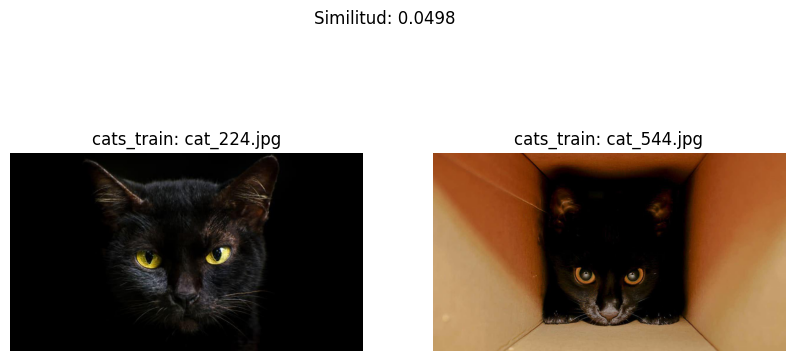

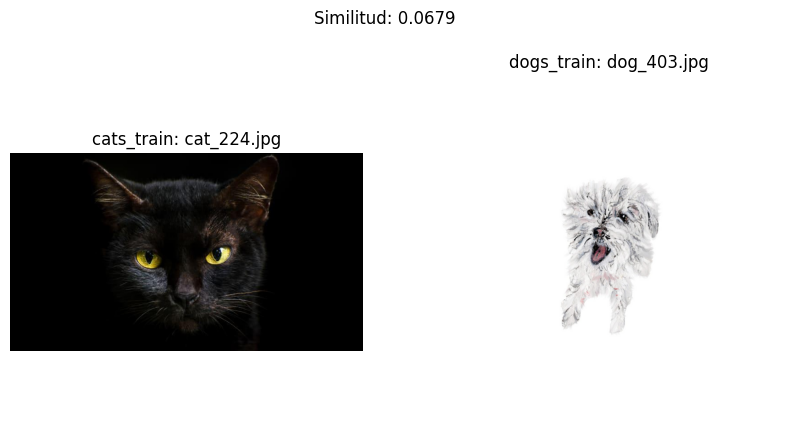

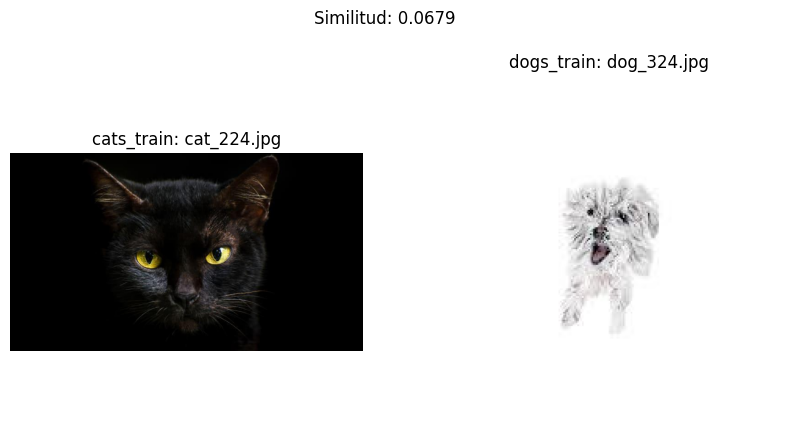

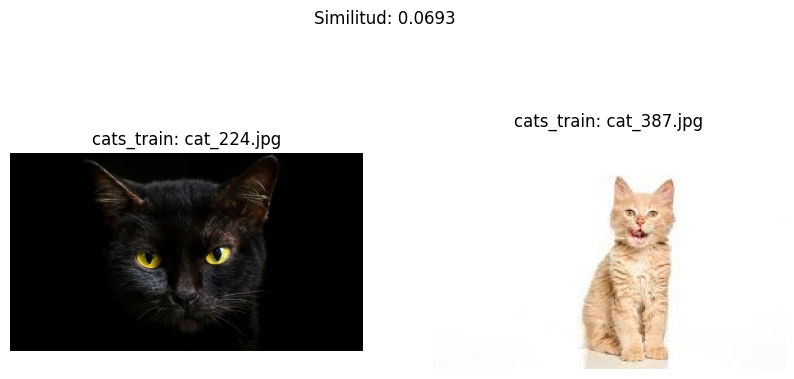

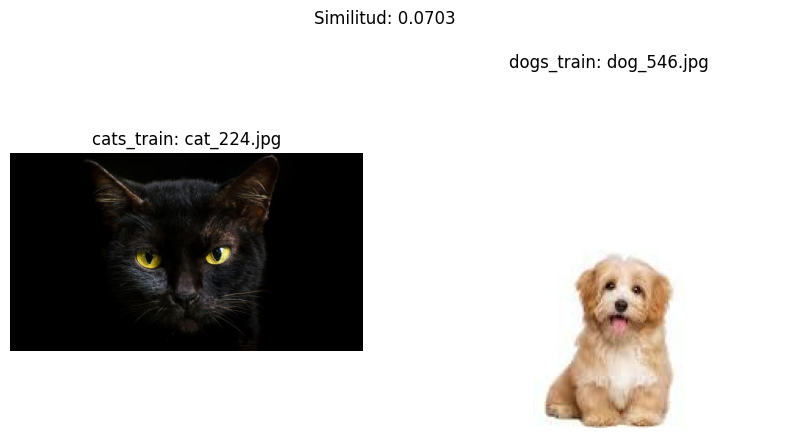

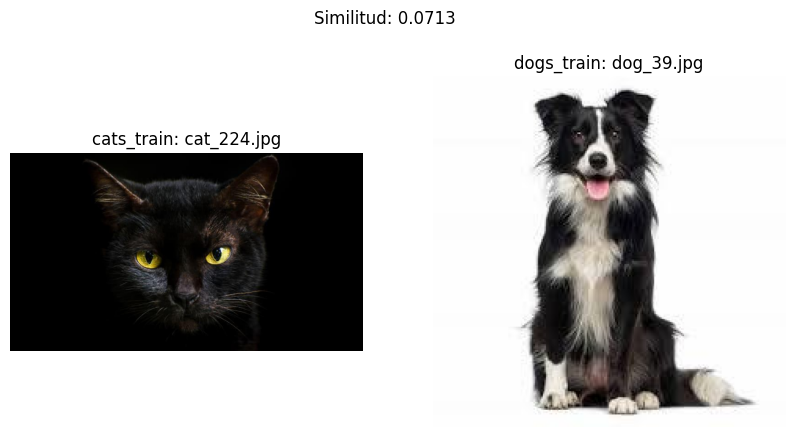

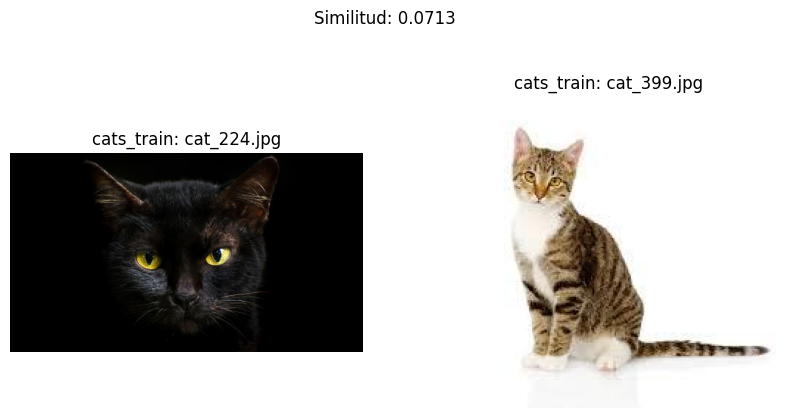

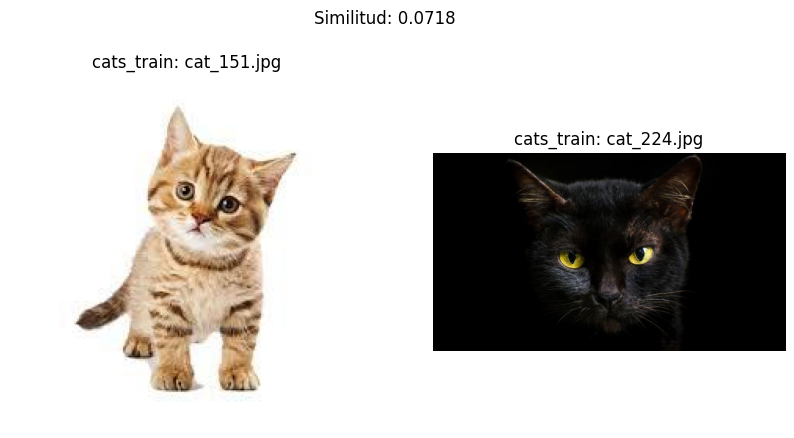

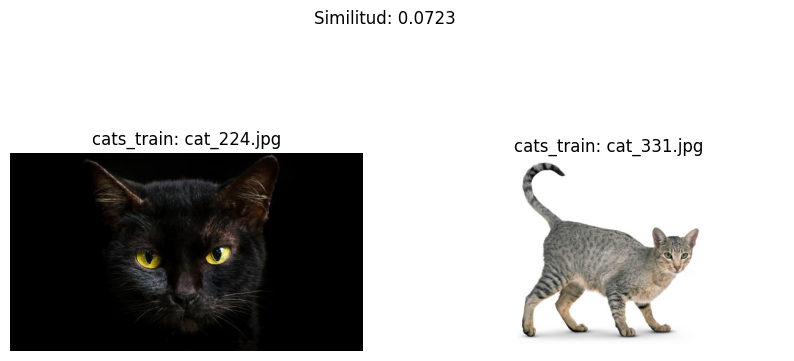

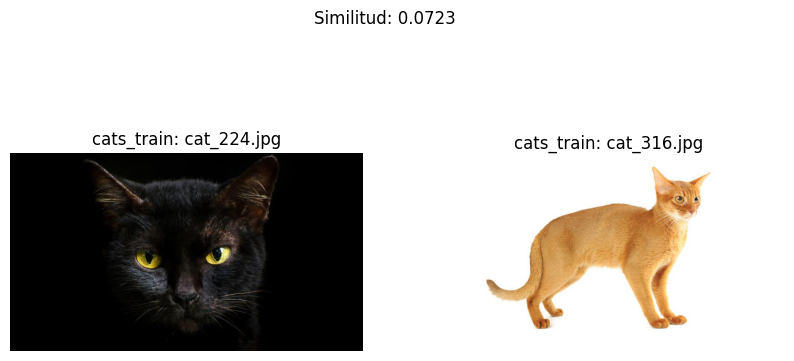

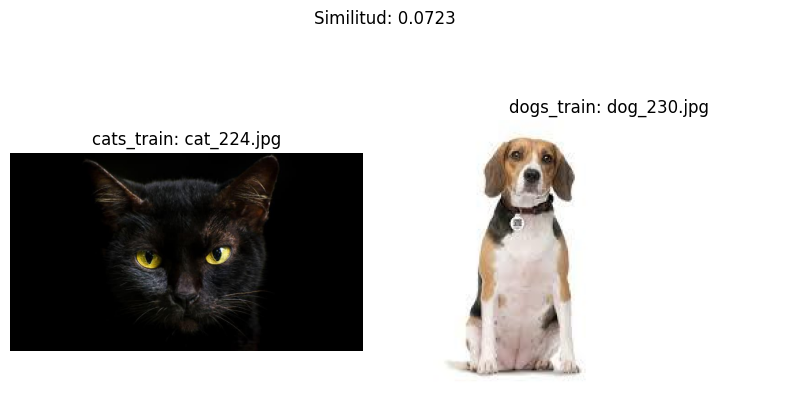

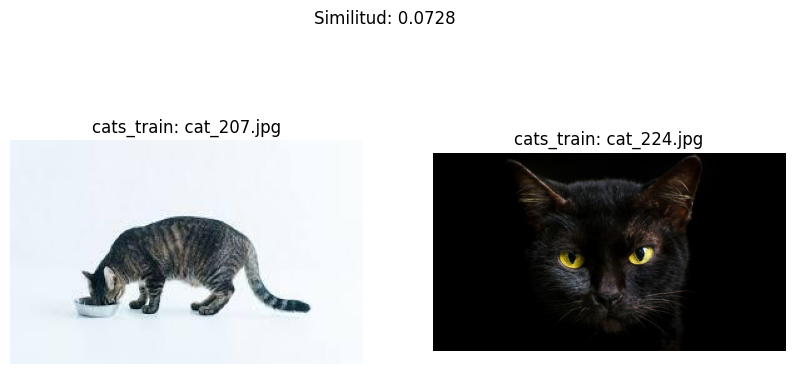

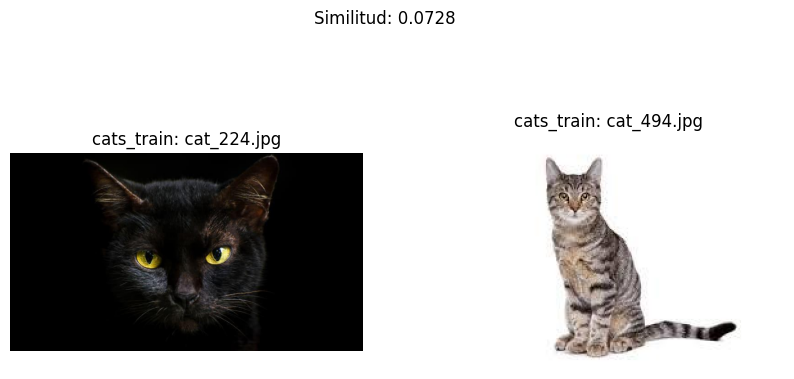

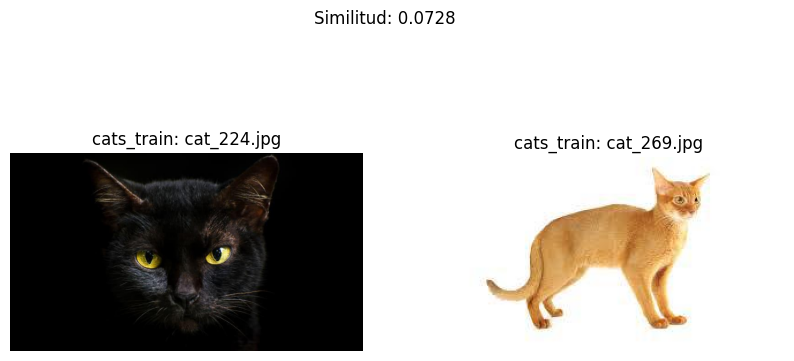

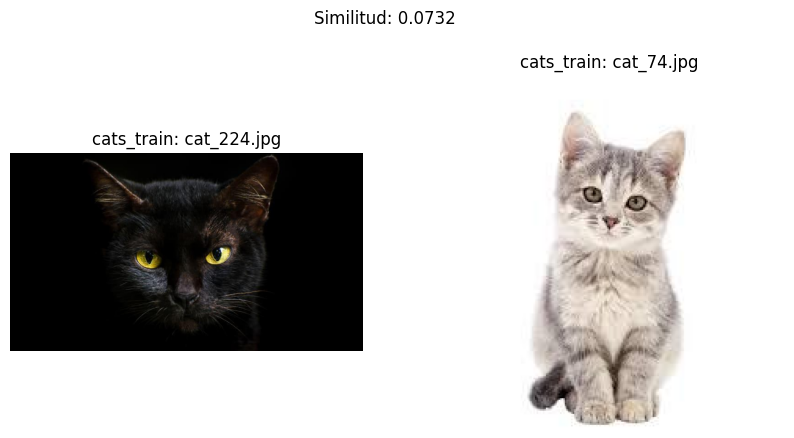

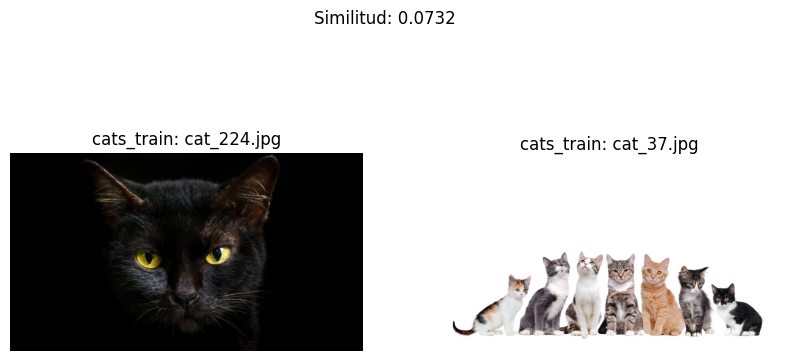

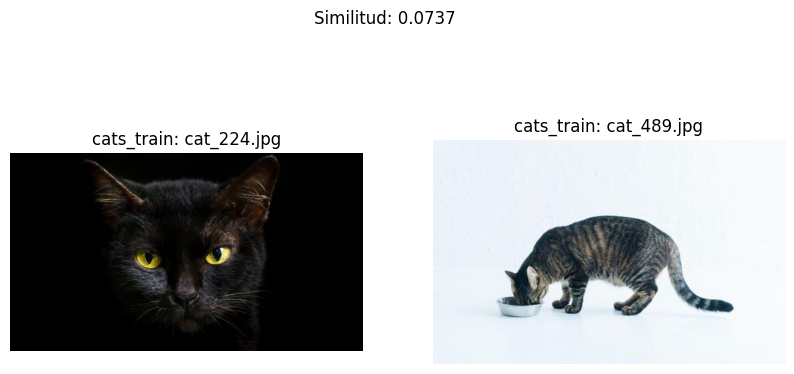

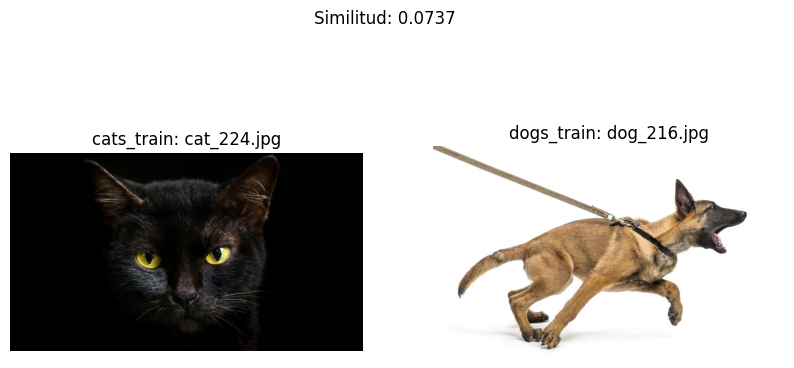

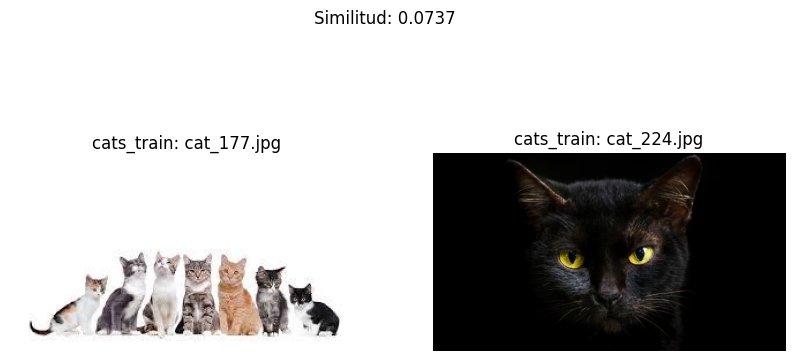

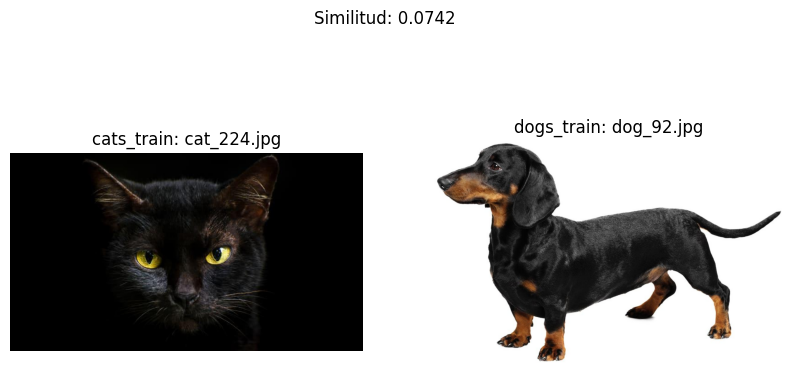

In [22]:

# Función para visualizar las imágenes menos similares en todo el dataset usando la matriz M  
def show_least_similar_across_dataset(estimator, class_names, filenames_dict):  
    print("Muestras menos similares en todo el dataset")  
    
    # Obtener la matriz de similitud para todo el dataset  
    M = estimator.M  
    
    # Ordenar los índices según las similitudes (de menor a mayor)  
    least_similar_indices = np.argsort(M, axis=None)  
    
    shown_pairs = set()  # Para rastrear los pares de índices ya mostrados  
    count = 0  
    show_samples = 20  # Número de pares de muestras para visualizar la similitud  
    
    images_to_show = []  # Lista para almacenar las imágenes y sus detalles  
    
    for idx in least_similar_indices:  
        if count >= show_samples:  
            break  
        
        # Convertimos el índice plano a 2D  
        idx_2d = np.unravel_index(idx, M.shape)  
        
        # Saltar las comparaciones de una muestra consigo misma  
        if idx_2d[0] == idx_2d[1]:  
            continue  
        
        # Crear un par ordenado de índices para prevenir duplicados  
        index_pair = tuple(sorted((idx_2d[0], idx_2d[1])))  
        
        # Verificamos si el par ya fue mostrado  
        if index_pair in shown_pairs:  
            continue  
        
        shown_pairs.add(index_pair)  
        
        source_idx, target_idx = index_pair  
        
        # Verificar que los índices estén dentro de los límites del dataset  
        if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):  
            source_filename = Path(filenames_dict[int(source_idx)])  
            target_filename = Path(filenames_dict[int(target_idx)])  
            
            # Determinar las clases de cada archivo  
            source_class = None  
            target_class = None  
            for class_intent, indices in estimator.class_indices.items():  
                if source_idx in indices:  
                    source_class = class_names[class_intent]  
                if target_idx in indices:  
                    target_class = class_names[class_intent]  
            
            # Mostrar las comparaciones  
            value = M[idx_2d]  
            print(f"\t{source_filename.name} ({source_class}) vs {target_filename.name} ({target_class}), Similitud: {value:.4f}")  
            
            # Agrega los detalles a la lista para visualización  
            images_to_show.append((source_filename, target_filename, source_class, target_class, value))  
            
            # Incrementar el contador ya que se ha mostrado un nuevo par  
            count += 1  
    
    # Luego, realiza la visualización de las imágenes  
    for source_filename, target_filename, source_class, target_class, value in images_to_show:  
        img_source = plt.imread(source_filename)  
        img_target = plt.imread(target_filename)  
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
        axs[0].imshow(img_source)  
        axs[0].set_title(f"{source_class}: {source_filename.name}")  
        axs[0].axis('off')  # Ocultar los ejes  
        axs[1].imshow(img_target)  
        axs[1].set_title(f"{target_class}: {target_filename.name}")  
        axs[1].axis('off')  # Ocultar los ejes  
        plt.suptitle(f"Similitud: {value:.4f}")  
        plt.show()  

# Llama a la función para visualizar  
show_least_similar_across_dataset(estimator, class_names_train, filenames_dict)